In [1]:
#### import random
from matplotlib import pyplot as plt
import random
import numpy as np
import pandas as pd
from scipy.ndimage.interpolation import shift
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from scipy import stats
import math
random.seed(1234)

plt.rcParams["figure.figsize"] = (20,10)

In [113]:
class Agent():
    '''
    The class defines the main characteristics of my agents
    They have some money and assets
    '''
    def __init__(self, money, confidence, model):
        self.money = 0
        
        if random.random () <0.4:
            self.confidence = random.random()*0.5 + 0.5
        else:
            self.confidence = random.random()
        
        self.asset = model.produce
        self.num_of_assets_owned = 0
        
        self.agent_keep_asset = list()
        self.num_of_keep = 0
        
        self.agent_buy_asset = list()
        self.num_of_buy = 0 
        
        self.agent_sell_asset = list()
        self.num_of_sell = 0
        
        self.error = stats.norm.rvs(loc = 0, scale = 5)

        '''
        Here I'm assigning agents to a Expectation Formation type randomly
        To keep things simple for now, agents will use the same decisions-making technique
        '''

        if random.random() <0.4:
            self.EP_type = 0 #1 - Agents with limited knowledge and predictive capabilities
        else:
            self.EP_type = 1 #0 - Agents with limited knowledge but better predictive capabilities
           
        
        '''
        Keeping track of all transactions agents make every time step
        '''
        self.transaction_history = list()
        if self.keep_asset:
            self.decision_keep = 1

        if self.sell_asset:
            self.decision_sell = 1
        
        if self.buy_asset:
            self.decision_buy = 1

        
        self.time = 0

        self.model = model

        '''
        Keeping track of predicted price.
        '''
        self.predict_price = 0
        self.AR_predictions = list()
        self.LR_predictions = list()
        
        
        
    def step(self):
        '''
        Two things happening every timestep:
        1) Agents will earn money
        2) Asset will step forward in time also
        3) Agents will fall into either 2 types of decision-making behaviours, simple linear regression or autoregression
        '''
        self.earn_money(20)
        
        
        self.time += 1
        
        '''
        If the agent falls into the limited knowledge and predictive capabilities type, 
        they use a simple linear regression to predict the next asset price
        '''

        if self.EP_type == 0:
            self.predict_AR()
            self.AR_decision()
            self.AR_predictions.append(self.predict_price)
        
        else:
            self.predict_regession()
            self.reg_decision()
            self.LR_predictions.append(self.predict_price)

        
        agent_sell_asset = list()       
        if self.transaction_history == 'sell':
            agent_sell_asset.append(agent)
        self.num_of_sell = len(self.agent_sell_asset)
        self.agent_sell_asset.append(self.num_of_sell)
        
        agent_buy_asset = list()       
        if self.transaction_history == 'buy':
            agent_buy_asset.append(agent)
        self.num_of_buy = len(self.agent_buy_asset)
        self.agent_buy_asset.append(self.num_of_buy)
        
        agent_keep_asset = list()       
        if self.transaction_history == 'keep':
            agent_keep_asset.append(agent)
        self.num_of_keep = len(self.agent_keep_asset)
        self.agent_keep_asset.append(self.num_of_keep)
        
    
            
        '''
        Then, if the predicted price equal actual asset price then they keep the asset, 
        if predicted price is less actual asset price they sell, 
        and if the predicted price is greater than asset price they sell
        '''
            
    
    def earn_money(self, amount):
        '''
        To introduce a possility of not earning disposable income every timestep, I included a probability
        '''
        if random.random( ) <0.2:
            self.money += amount
        
            
    def predict_regession(self):
        '''
        Expectation formation behaviour type 1:
        Simple linear regession predict the asset price considering previous asset prices. 
        Following each timestep, actual asset prices are added to the price history. 
        '''        
        y=self.asset.price_history_LR.reshape(-1, 1)
        X=self.asset.time_history_LR.reshape(-1, 1)
        #print(y, X, y.shape, X.shape)
        reg=LinearRegression().fit(X,y)
        next_time = np.zeros((1, 1))
        next_time[0][0] = model.time + 1
        
        if random.random()> 0.5:
            next_time_1 = next_time + self.error
            self.predict_price= reg.predict(next_time_1)
            self.LR_predictions.append(self.predict_price)
        else:
            self.predict_price= reg.predict(next_time)
            self.LR_predictions.append(self.predict_price)


    def predict_AR(self):
        '''
        Expectation formation behaviour type 2:
        Autoregessive predictor
        '''
        y1=self.asset.price_history_AR
        log_x = np.log(y1)
        log_x_shift = shift(log_x, 1, cval=0)
        log_of_x = log_x - log_x_shift
        #log_x_shift = log_x.shift()
        #log_x_shift = log_x - log_x.shift()
#        print(log_x_shift)
#        get_stationarity(log_of_x)
        
        decomposition = seasonal_decompose(log_x, period= 1) 
        model = ARIMA(log_x, order=(1,2,0))
        results = model.fit(disp=-1)
#        plt.plot(log_x_shift)
#        plt.plot(results.fittedvalues, color='red')
           
        predictions_ARIMA_diff = pd.Series(results.fittedvalues)
        predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
        predictions_ARIMA_log = pd.Series(log_x)
        predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
        predictions_ARIMA = np.exp(predictions_ARIMA_log)
        predictions_ARIMA_log.index += 0
        
        if random.random()> 0.5:
            predictions = predictions_ARIMA.iloc[-1] + self.error
            self.predict_price= predictions
            self.AR_predictions.append(self.predict_price)
        else:
            self.predict_price= predictions_ARIMA.iloc[-1]
            self.AR_predictions.append(self.predict_price)
            
#         plt.plot(y1)
#         self.predict_price = predictions_ARIMA.iloc[-1]
#         print(self.predict_price)
#         print(type(self.predict_price))
#         self.AR_predictions.append(self.predict_price)
    
#         plt.plot(predictions_ARIMA.iloc[-1])

    def AR_decision(self):
        if (self.predict_price > self.asset.update_price) and (self.money > self.asset.update_price):
            self.buy_asset()
            self.transaction_history.append('buy')
        elif self.predict_price  == self.asset.update_price:
            self.keep_asset()
            self.transaction_history.append('keep')
        elif self.predict_price  < self.asset.update_price:
            self.sell_asset()
            self.transaction_history.append('sell')
            
        print('My Autoregressive Price Prediction = {0}, Decision = {1}, My Money = {2}'.format(self.predict_price, self.transaction_history, self.money))
          
    def reg_decision(self):
        if self.confidence > 0.2:
            if (self.predict_price[0][0] > self.asset.update_price) and (self.money > self.asset.update_price):
                self.buy_asset()
                self.transaction_history.append('buy')
                
            elif self.predict_price[0][0] == self.asset.update_price:
                self.keep_asset()
                self.transaction_history.append('keep')

            elif (self.predict_price[0][0] < self.asset.update_price) and self.num_of_assets_owned > 1 :
                self.sell_asset()
                self.transaction_history.append('sell')
            print('My Regressions Price Prediction = {0}, Decision = {1}, My Money = {2},  My confidence = {3}'.format(self.predict_price, self.transaction_history, self.money,  self.confidence))
        else:
            if self.keep_asset:
                if self.num_of_sell > model.population/1.5:
                    self.sell_asset()
                    self.transaction_history.append('sell')
                    print('I feel forced to sell')
                elif self.num_of_buy > model.population/1.5: 
                    self.buy_asset()
                    self.transaction_history.append('buy')
                    print('I feel forced to buy')
            print('My Regressions Price Prediction = {0}, Decision = {1}, My Money = {2},  My confidence = {3}'.format(self.predict_price, self.transaction_history, self.money,  self.confidence))

    def keep_asset(self):
        self.num_of_assets_owned += 0 
        self.money += 0
    
    def sell_asset(self):
        self.num_of_assets_owned -= 1 
        self.money += self.asset.price
    
    def buy_asset(self):
        self.num_of_assets_owned += 1
        self.money -= self.asset.price
    
        

In [114]:
class Asset():
    
    def __init__(self):
        '''
        Contains, asset price, a time log and their histories. 
        backdated prices that are randomly generated for a previous time periods.
        '''
        self.price = 50
        self.time = 1
        self.backdated_LR = (50, 49, 51, 53, 50 ,47 ,55, 48 ,53, 55) 
        self.backdated_AR = (50, 49, 51, 53, 50)
        
        
        
        for i in range(len(self.backdated_LR)):
            self.price_history_LR = list(self.backdated_LR)
        
        self.price_history_LR = np.array(self.price_history_LR)
        self.price_history_LR = self.price_history_LR.reshape(-1, 1)
        
        for i in range(len(self.backdated_AR)):
            self.price_history_AR = list(self.backdated_AR)
        
        self.price_history_AR = np.array(self.price_history_AR)
        self.price_history_AR = self.price_history_AR.reshape(-1, 1)
        
      
        self.backdated_time_LR = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)
        for i in range(len(self.backdated_time_LR)):
            self.time_history_LR = list(self.backdated_time_LR)
        
        self.time_history_LR = np.array(self.time_history_LR)
        self.time_history_LR = self.time_history_LR.reshape(-1, 1)
        
        self.backdated_time_AR = (0, 1, 2, 3, 4)
        for i in range(len(self.backdated_time_AR)):
            self.time_history_AR = list(self.backdated_time_AR)
        
        self.time_history_AR = np.array(self.time_history_AR)
        self.time_history_AR = self.time_history_AR.reshape(-1, 1)
        
    def step(self):
        '''
        Every time step, the price will update, keeping a log of time.
        '''
        self.update_price = stats.norm.rvs(loc = 47, scale = 3)
        self.time += 1
        
#         self.price_history.append(self.price)
        self.price_history_AR = np.append(self.update_price, self.price_history_AR, self.price)
        self.price_history_LR = np.append(self.update_price, self.price_history_LR, self.price)

#         self.time_history.append(self.time)
        self.time_history_AR = np.append(self.time_history_AR, self.time)
        self.time_history_LR = np.append(self.time_history_LR, self.time)
#         plt.plot(self.time_history)
        

In [115]:
class Model():
    '''
    This class includes functions suchas popuation, model iterations, and a step and run function
    '''
    def __init__(self,population, num_iterations):
        self.population = population
        
        '''
        Renaming the Asset, 'Produce' and associate my agents to it. 
        '''
        self.produce = Asset()
        self.agents = [Agent(0, 0, self) for i in range (self.population)]


        self.num_iterations = num_iterations
        
        '''
        Recording time
        '''
        self.time = 0
        
    def step(self):
        '''
        Steps model forwards
        '''
        # Step Asset price
        self.produce.step()
        print('Market Price:{}'.format( self.produce.update_price))


        # Step agents 
        for i, agent in enumerate(self.agents):
            print('Agent: {0}/{1}'.format(i, self.population))
            agent.step()
        
        # Step time
        self.time += 1
    
  
    def run(self):
        '''
        For every time period, and for every agent in my list of agents, run the step function
        '''
        for t in range(self.num_iterations):
            print('Timestep: {}'.format(self.time))
            self.step()

In [116]:
# if __name__ == "__main__":
model = Model(population =5, num_iterations=50)
model.run()

Timestep: 0
Market Price:48.30299809929077
Agent: 0/5
My Autoregressive Price Prediction = 56.15417948483295, Decision = [], My Money = 20
Agent: 1/5
My Regressions Price Prediction = [[50.42062033]], Decision = [], My Money = 0,  My confidence = 0.9102490289691344
Agent: 2/5
My Autoregressive Price Prediction = 51.05525349122663, Decision = [], My Money = 0
Agent: 3/5
My Regressions Price Prediction = [[50.56821085]], Decision = [], My Money = 0,  My confidence = 0.09170549547106488
Agent: 4/5
My Regressions Price Prediction = [[50.42817066]], Decision = [], My Money = 0,  My confidence = 0.3490208223741027
Timestep: 1
Market Price:46.35461358715234
Agent: 0/5
My Autoregressive Price Prediction = 49.99999999999999, Decision = [], My Money = 40
Agent: 1/5
My Regressions Price Prediction = [[50.15547342]], Decision = [], My Money = 0,  My confidence = 0.9102490289691344
Agent: 2/5
My Autoregressive Price Prediction = 51.05525349122663, Decision = [], My Money = 20
Agent: 3/5
My Regressi

ValueError: x and y can be no greater than 2-D, but have shapes (100,) and (100, 1, 1)

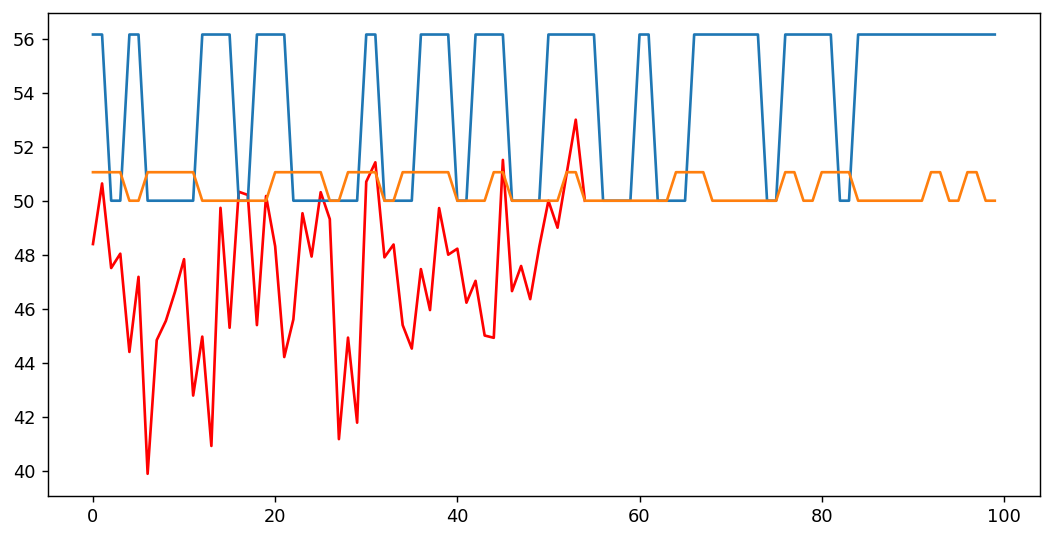

In [117]:
fig, ax = plt.subplots(num=None, figsize=(10, 5), dpi=128, facecolor='w', edgecolor='k')
        # Do a scatter plot
ax.plot(model.produce.price_history_AR, c="red", label=" Asset Market Price" ) 
for agent in model.agents:
    if agent.EP_type == 0:
#         print(agent.AR_predictions)
        ax.plot(agent.AR_predictions, label='agent')
for agent in model.agents:
    if agent.EP_type ==1:
        ax.plot(agent.LR_predictions, label='agent')
# ax.plot(model.agents[.predict_price, c="red") 
ax.set_title("Market Price v Predicted Prices")
ax.set_xlabel("Iteration (time)")
ax.set_ylabel("Asset Price")
ax.legend(loc='upper left')